# Thruster firings are removed from the results

1. Find all times for thruster firings, i.e. 524288,524288\*2
2. Check for CR 8192 flags
3. Define final cleaned isflare sequence
4. Average all test LCs

## 1. Find and remove thruster firings

In [5]:
%matplotlib inline
import matplotlib.rcsetup as rcsetup
import matplotlib
print(rcsetup.all_backends)
matplotlib.matplotlib_fname()

['GTK', 'GTKAgg', 'GTKCairo', 'MacOSX', 'Qt4Agg', 'Qt5Agg', 'TkAgg', 'WX', 'WXAgg', 'GTK3Cairo', 'GTK3Agg', 'WebAgg', 'nbAgg', 'agg', 'cairo', 'gdk', 'pdf', 'pgf', 'ps', 'svg', 'template']


'/usr/local/lib/python3.5/dist-packages/matplotlib/mpl-data/matplotlibrc'

In [6]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import time
import os
import math
import numpy as np
import pyke as pk
import pandas as pd
import k2flix
import matplotlib.pyplot as plt


def find_nearest(array,value):

    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return array[idx-1], idx-1
    else:
        return array[idx], idx


def tpf_time_match(flux, tpf):

    flags = []
    timed = []
    quality = tpf.hdulist[1].data['QUALITY']
    print(time.clock())
    for id_,row in flux.iterrows():

        t, idx_ = find_nearest(tpf.bkjd(), row.time)
        timed.append(t)
        flags.append(quality[idx_])

    flux['tpf_flags'] = flags
    flux['tpf_time'] = timed
    return flux



def wrap_tpf_time_match(oid_list,test):
    tpfs, flux, flares = dict(), dict(), dict()
    for oid in oid_list:
        tpfs[oid] = k2flix.TargetPixelFile('ktwo{}-c05_lpd-targ.fits.gz'.format(oid))
        
        flares[oid] = pd.read_csv('results/{}/{}_flares.csv'.format(test,oid),
                                 usecols=['istart','istop'],
                                 dtype=int)
        flux[oid] = pd.read_csv('results/{}/{}_flux.csv'.format(test,oid),usecols=['flux_gap','time','flux_model'])
        flux[oid] = tpf_time_match(flux[oid],tpfs[oid])
        flux[oid].to_csv('results/{}/{}_tpf_times_FLUX.csv'.format(test,oid))
        #flux[oid] = pd.read_csv('results/{}/{}_tpf_times_FLUX.csv'.format(test,oid),
        #                        usecols=['flux_gap','time','flux_model','tpf_time','tpf_flags'])
    return flux, flares, tpfs
                                          
def edges_to_bool(start_stop,flux):
    
    rangeflare = []
    for i,row in start_stop.iterrows():
            rangeflare.append(list(range(row.istart,row.istop+1)))
    isflare = np.zeros_like(flux.time.tolist())
    rangeflare = [item for sublist in rangeflare for item in sublist]

    np.put(isflare,rangeflare,np.ones_like(rangeflare))

    return isflare  



def remove_thruster_firings(tpfs, flux, flares, oid):
    remove = []
    for i in range(len(tpfs[oid].hdulist[1].data['FLUX'])): 
        if tpfs[oid].hdulist[1].data['QUALITY'][i] > 524288:#flag values are summed up!
            remove.append(tpfs[oid].bkjd(i))
            try:
                remove.append(tpfs[oid].bkjd(i-1))
            except IndexError:
                print('IndexError -1')
                pass
            try:
                remove.append(tpfs[oid].bkjd(i+1))
            except IndexError:
                print('IndexError +1')
                pass

    remove_id = [flux[oid].index.values[np.round(flux[oid].time,6) == np.round(remove_time,6)][0] for remove_time in sorted(list(set(remove)))]
    isflare = edges_to_bool(flares[oid],flux[oid])
    new_isflare = np.array(isflare)
    new_flags = np.array(flux[oid].tpf_flags)
    for id_ in remove_id:
        if isflare[id_] == 1.:
            for j, row in flares[oid].iterrows():
                if (row.istart <= id_) & (row.istop+1 >=id_):
                    new_isflare[row.istart:row.istop+1] = 0
                    new_flags[row.istart:row.istop+1] = 0

    flux[oid]['isflare'] = isflare
    flux[oid]['new_isflare'] = new_isflare
    flux[oid]['new_tpf_flags'] = new_flags
    return


def remove_systematics(flux,test,oid):
    s = pd.read_csv('results/{}/systematics.csv'.format(test),names=['systematics']).systematics.tolist()
    flux[oid]['tpf_flags_wo_systematics'] = np.array(flux[oid].tpf_flags)
    flux[oid]['isflare_wo_systematics'] = np.array(flux[oid]['isflare'])
    flux[oid]['tpf_flags_wo_systematics'].iloc[s]= 0
    flux[oid]['isflare_wo_systematics'].iloc[s]= 0
    return

def flag_df(flux):
    index = [1,8192,524288]
    columns = ['>',
               '>_after_thruster_removal',
               '>_after_systematics_removal',
               '>_left_overall',
               '>_coinciding_with_flare_candidates',
               '>_coinciding_with_clean_flare_candidates',
              ]
    flags = pd.DataFrame(index=index, columns=columns)
    for flag in index:
        flags[columns[0]].loc[flag] = flux[flux.tpf_flags >= flag].shape[0]
        flags[columns[1]].loc[flag] = flux[flux.new_tpf_flags >= flag].shape[0]
        flags[columns[2]].loc[flag] = flux[flux.tpf_flags_wo_systematics >= flag].shape[0]
        flags[columns[3]].loc[flag] = flux[(flux.tpf_flags_wo_systematics >= flag) & (flux.new_tpf_flags >= flag)].shape[0]
        flags[columns[4]].loc[flag] = flux[(flux.isflare == True) & (flux.tpf_flags >= flag)].shape[0]
        flags[columns[5]].loc[flag] = flux[(flux.isflare_no_sys_no_thruster == True) & (flux.tpf_flags >= flag)].shape[0]
    return flags.T



os.chdir('/home/ekaterina/Documents/appaloosa/stars_shortlist/M67')
oid_list = pd.read_csv('M67_short.txt',names=['EPIC'])
oid_list = oid_list.EPIC.tolist()
test = 'test_22'
o = 211412571
#oid_list = ['211410963','211418176']#,'211418561','211412571']

flux, flares, tpfs = wrap_tpf_time_match(oid_list, test)

3.429319
4.164397
4.954611
5.667348
6.479135
7.231317
7.964709
8.742331
9.504113
10.352898
11.176202
11.969484
12.714273
13.551025
14.474376
15.291127
16.067006
16.851518
17.670209
18.503721
19.273705


In [7]:
flares[o].tail()

,istart,istop
99,3490,3491
100,3533,3534
101,3560,3561
102,3572,3573
103,3600,3601


In [8]:
for oid in oid_list:
    remove_thruster_firings(tpfs, flux, flares, oid)
    remove_systematics(flux, test, oid)
    


In [9]:
flux[o].iloc[1518:1525]

,flux_gap,flux_model,time,tpf_flags,tpf_time,isflare,new_isflare,new_tpf_flags,tpf_flags_wo_systematics,isflare_wo_systematics
1518,2770.972716,2771.751789,2337.626687,0,2337.626687,0.0,0.0,0,0,0.0
1519,2773.394914,2771.859266,2337.647119,0,2337.647119,0.0,0.0,0,0,0.0
1520,2775.455254,2772.124861,2337.667551,0,2337.667551,0.0,0.0,0,0,0.0
1521,2779.131991,2772.549457,2337.687982,1048576,2337.687982,0.0,0.0,1048576,1048576,0.0
1522,2771.125793,2773.101271,2337.708414,0,2337.708414,0.0,0.0,0,0,0.0
1523,2772.048708,2773.746554,2337.728846,0,2337.728846,0.0,0.0,0,0,0.0
1524,2769.636817,2774.451567,2337.749277,0,2337.749277,0.0,0.0,0,0,0.0


## 2. Check for CR flag

In [10]:
flux[o][(flux[o].tpf_flags_wo_systematics >= 8192) & (flux[o].new_tpf_flags >= 8192)  & (flux[o].isflare >0)]

,flux_gap,flux_model,time,tpf_flags,tpf_time,isflare,new_isflare,new_tpf_flags,tpf_flags_wo_systematics,isflare_wo_systematics
259,2801.371991,2769.287771,2311.902949,8192,2311.902949,1.0,1.0,8192,8192,1.0
260,2849.852771,2769.365077,2311.923381,10240,2311.923381,1.0,1.0,10240,10240,1.0
512,2844.750296,2770.634496,2317.072257,10240,2317.072257,1.0,1.0,10240,10240,1.0
535,2797.235743,2769.517481,2317.542193,8192,2317.542193,1.0,1.0,8192,8192,1.0
536,2807.841240,2769.365795,2317.562625,8192,2317.562625,1.0,1.0,8192,8192,1.0
800,2816.470965,2781.030806,2322.956658,10240,2322.956658,1.0,1.0,10240,10240,1.0
824,2816.305127,2780.084872,2323.447023,8192,2323.447023,1.0,1.0,8192,8192,1.0
848,2816.881588,2779.382535,2323.937388,8192,2323.937388,1.0,1.0,8192,8192,1.0
872,2811.921866,2779.623770,2324.427753,8192,2324.427753,1.0,1.0,8192,8192,1.0
895,2817.525727,2781.730135,2324.897686,8192,2324.897686,1.0,1.0,8192,8192,1.0


In [11]:
10240-8192

2048

## 3. Create final isflare sequence

In [12]:
def bool_to_edges(isflare):
    
    c, start, stop = False, [], []
    isflare = list(isflare)
    for id_, bool_ in enumerate(isflare):
        if c == False and bool_ == True:
            start.append(id_)
            c = True
        elif c == True and bool_ == False:
            stop.append(id_-1)
            c = False
    start_stop = pd.DataFrame({'istart':start},dtype=int)#,'istop':stop})
    start_stop = start_stop.join(pd.Series(stop,name='istop',dtype=int))
    return start_stop   

for oid in oid_list:
    flux[oid]['isflare_no_sys_no_thruster'] = (flux[oid].new_isflare == 1.) & (flux[oid].isflare_wo_systematics == 1.)
    start_stop = bool_to_edges(flux[oid].isflare_no_sys_no_thruster)
    flares[oid] = flares[oid].join(start_stop,rsuffix='_no_sys_no_thruster')
    flux[oid].to_csv('results/{}/{}_tpf_times_FLUX.csv'.format(test,oid))
flares[o]

,istart,istop,istart_no_sys_no_thruster,istop_no_sys_no_thruster
0,171,172,171.0,172.0
1,248,249,259.0,260.0
2,259,260,291.0,292.0
3,291,292,512.0,513.0
4,333,334,535.0,536.0
5,404,405,800.0,801.0
6,428,430,824.0,825.0
7,452,453,848.0,849.0
8,512,513,872.0,873.0
9,524,525,895.0,896.0


## 4. Compile a table averageing over all test LCs

In [13]:
summary = dict()
for oid in oid_list:
    summary[oid] = flag_df(flux[oid]).stack()
sum_ = summary[oid_list[0]].to_frame(name=oid_list[0])
#print(sum_)
for oid in oid_list[1:]:
    sum_[oid] = summary[oid]

#sum_ = sum_/len(oid_list)

print(sum_.mean(axis=1))
print(sum_.std(axis=1))

>                                         1         362.238095
                                          8192      355.666667
                                          524288    201.000000
>_after_thruster_removal                  1         339.904762
                                          8192      334.333333
                                          524288    190.142857
>_after_systematics_removal               1         358.428571
                                          8192      352.285714
                                          524288    199.000000
>_left_overall                            1         337.476190
                                          8192      332.333333
                                          524288    188.761905
>_coinciding_with_flare_candidates        1          33.380952
                                          8192       29.380952
                                          524288     10.857143
>_coinciding_with_clean_flare_candidates  1          10

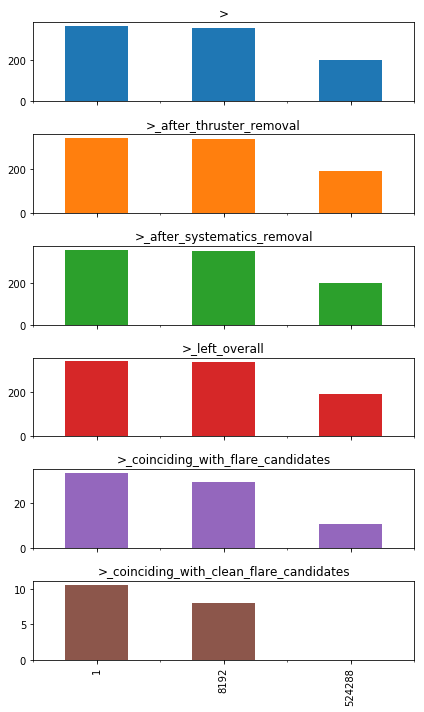

In [14]:

p = sum_.mean(axis=1).unstack(level=0).plot(kind='bar', subplots=True,figsize=(6,10),legend=False)
plt.tight_layout()
#plt.show()

(2400, 2500)

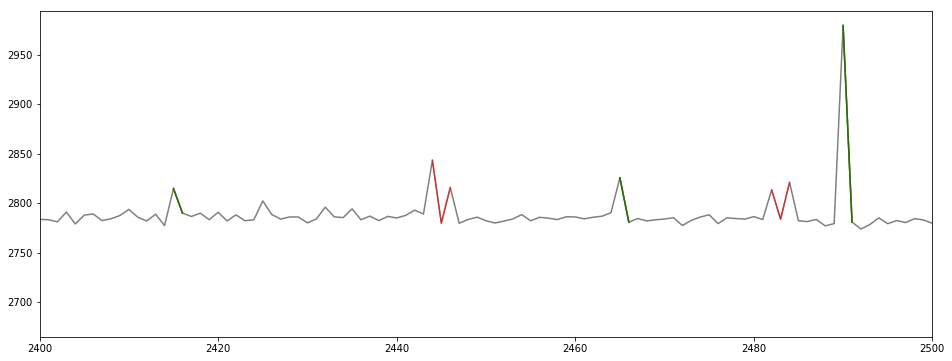

In [15]:
oid = o
plt.figure(figsize=(16,6))
plt.plot(flux[oid].flux_gap,color='black',alpha=0.5)
for id_, row in flares[oid].iterrows():
    plt.plot(flux[oid].flux_gap.iloc[int(row.istart):int(row.istop+1)],color='red',alpha=0.6)
new_flares = flares[oid][['istart_no_sys_no_thruster','istop_no_sys_no_thruster']]
new_flares.dropna(inplace=True)
for id_, row in new_flares.iterrows():
    plt.plot(flux[oid].flux_gap.iloc[int(row.istart_no_sys_no_thruster):int(row.istop_no_sys_no_thruster+1)],color='green',alpha=0.9)   
plt.xlim(2400,2500)

In [16]:
for oid in oid_list:
    flares[oid].to_csv('results/{}/{}_flares.csv'.format(test,oid))